In [193]:
import pandas as pd
import numpy as np

In [194]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [195]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

2.3.1


In [196]:
df = pd.read_csv("cars.csv", sep=';', encoding='utf-8')

In [201]:
df.shape

(108536, 18)

In [198]:
df.columns

Index(['brand', 'currency', 'description', 'model', 'price', 'url', 'year',
       'Город', 'Коробка передач', 'Кузов', 'Объем двигателя, л', 'Привод',
       'Растаможен', 'Руль', 'Цвет', 'Пробег', 'Наличие', 'VIN'],
      dtype='object')

In [202]:
df.head(1)

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,"Объем двигателя, л",Привод,Растаможен,Руль,Цвет,Пробег,Наличие,VIN
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,5.5 (бензин),полный привод,Да,слева,черный металлик,NaN,NaN,NaN


In [203]:
df['Пробег'] = pd.to_numeric(df['Пробег'].str[:-3].str.replace(' ', ''))

In [204]:
df['Объем двигателя, л'].isna().sum()

28

In [205]:
mode = df['Объем двигателя, л'].mode()[0]

In [206]:
df['Объем двигателя, л'].fillna(mode, inplace=True)

In [207]:
df['Литры'] = [float(i.split()[0]) for i in df['Объем двигателя, л']]

In [208]:
df['Тип топлива'] = [i.split()[1].strip('()') for i in df['Объем двигателя, л']]

In [211]:
na_table = np.sum(df.isnull())/df.shape[0]

In [212]:
round(na_table[na_table != 0], 3) * 100

description     4.8
model           0.0
Привод         12.6
Руль            0.0
Цвет            9.8
Пробег         40.3
Наличие        96.2
VIN            95.7
dtype: float64

Пробег, наличие, VIN исключаем

In [213]:
minimum_cols = ['Город', 'brand', 'model', 'Коробка передач', 'Кузов', 'Растаможен']

In [214]:
for column in minimum_cols:
    df[column] = df[column].fillna('Other')

In [215]:
for col in minimum_cols:
    counts = (df[col].value_counts() <= 5)
    df[col] = df[col].apply(lambda x: 'Other' if counts.loc[x] == True else x)

In [216]:
round(df.describe(), 2)

,price,year,Пробег,Литры
count,1.085360e+05,108536.00,64816.00,108536.00
mean,3.627690e+06,2003.36,234014.86,2.33
std,5.502069e+06,8.96,612266.60,0.91
min,5.500000e+02,1913.00,1.00,0.08
25%,1.000000e+06,1996.00,76000.00,1.60
50%,2.000000e+06,2004.00,140747.50,2.00
75%,4.000000e+06,2011.00,234000.00,2.70
max,2.600000e+08,2019.00,22222222.00,9.90


In [217]:
correlations = df.select_dtypes(include=['float64', 'int64']).corr()
correlations

,price,year,Пробег,Литры
price,1.000000,0.443605,-0.118162,0.458011
year,0.443605,1.000000,-0.218066,0.048122
Пробег,-0.118162,-0.218066,1.000000,-0.025442
Литры,0.458011,0.048122,-0.025442,1.000000


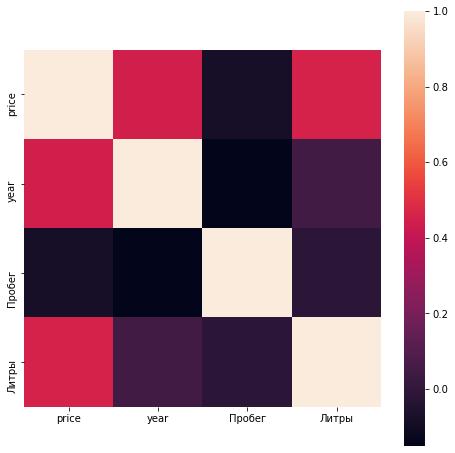

In [161]:
plt.figure(figsize=(8, 8))
sns.heatmap(correlations, square=True)
plt.show()

In [42]:
cat_columns = ['Город', 'brand', 'model', 'Коробка передач',\
                      'Кузов', 'Привод', 'Растаможен', 'Руль', 'Цвет', 'Тип топлива']

In [168]:
df.groupby('Город').mean().price.sort_values()

Город
Аманкарагай    4.100000e+05
Глубокое       7.613333e+05
Ботакара       7.737500e+05
Шантобе        8.166667e+05
Балпык би      8.475000e+05
                   ...     
Барнаул        8.372222e+06
Саратов        1.126000e+07
Новосибирск    1.980172e+07
Самара         2.028702e+07
Москва         3.067562e+07
Name: price, Length: 226, dtype: float64

In [167]:
df.groupby('brand').mean().price.sort_values()

brand
Москвич             3.748851e+05
ИЖ                  5.676488e+05
ЛуАЗ                7.294667e+05
ЗАЗ                 1.043094e+06
Opel                1.097156e+06
                        ...     
Maserati            1.692500e+07
Bentley             2.505503e+07
Tesla               4.110136e+07
Rolls-Royce         7.069333e+07
Mercedes-Maybach    7.443462e+07
Name: price, Length: 84, dtype: float64

In [166]:
df.groupby('model').mean().price.sort_values()

model
2125 Комби          2.283333e+05
Ascona              2.552380e+05
11113 Ока           3.134000e+05
1111 Ока            3.266667e+05
412                 3.384211e+05
                        ...     
AMG 63 GLE Coupe    4.388146e+07
S 560               4.706169e+07
G 63 AMG            5.821719e+07
Model X             5.830000e+07
Ghost               7.665000e+07
Name: price, Length: 935, dtype: float64

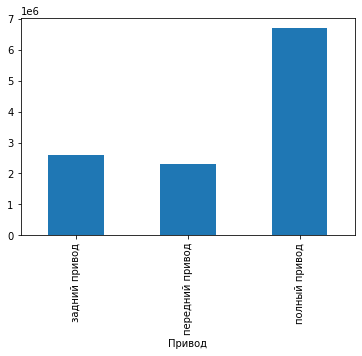

In [43]:
df.groupby('Привод').mean().price.plot(kind='bar')
plt.show()

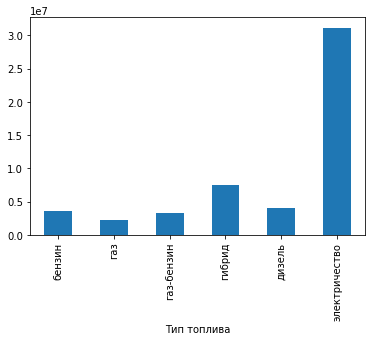

In [44]:
df.groupby('Тип топлива').mean().price.plot(kind='bar')
plt.show()

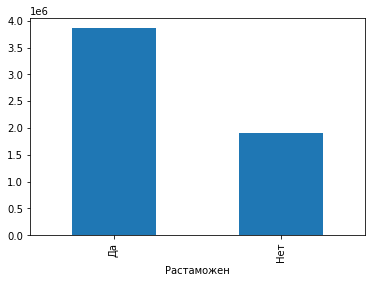

In [45]:
df.groupby('Растаможен').mean().price.plot(kind='bar')
plt.show()

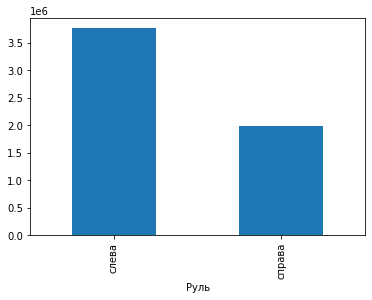

In [46]:
df.groupby('Руль').mean().price.plot(kind='bar')
plt.show()

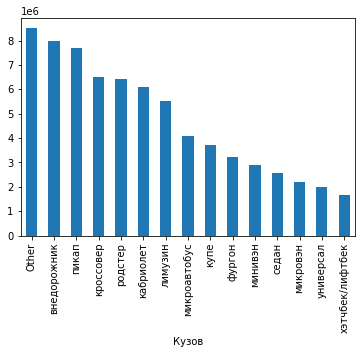

In [47]:
df.groupby('Кузов').mean().price.sort_values(ascending=False).plot(kind='bar')
plt.show()

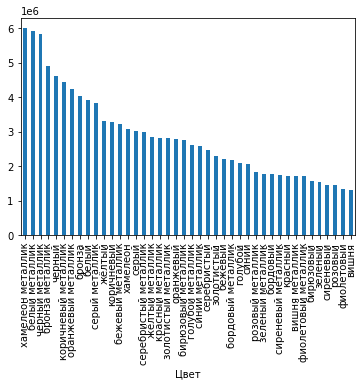

In [48]:
df.groupby('Цвет').mean().price.sort_values(ascending=False).plot(kind='bar')
plt.show()

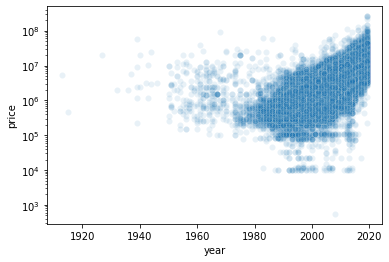

In [49]:
splot = sns.scatterplot(y='price', x='year', data=df, alpha=0.1)
splot.set(yscale="log")
plt.show()

In [50]:
num_columns = ['price', 'year', 'Литры', 'Пробег']

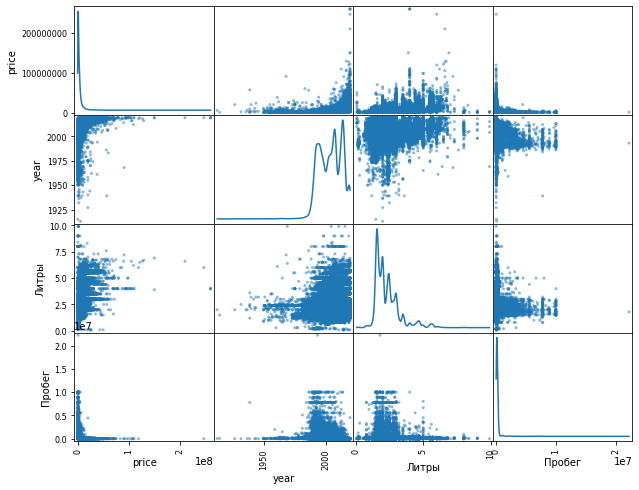

In [51]:
pd.plotting.scatter_matrix(df[num_columns], diagonal='kde', figsize=(10, 8))
plt.show()

In [220]:
na_table = np.sum(df.isnull())/df.shape[0]

In [221]:
round(na_table[na_table != 0], 3) * 100

description     4.8
Привод         12.6
Руль            0.0
Цвет            9.8
Пробег         40.3
Наличие        96.2
VIN            95.7
dtype: float64

Заполним цвет, руль и привод модой. Остальные

In [223]:
for column in ['Цвет', 'Руль', 'Привод']:
    df[column].fillna(df[column].mode()[0], inplace=True)

Убран руль и город

In [250]:
cat_columns = ['brand', 'model', 'Коробка передач',\
                      'Кузов', 'Привод', 'Цвет', 'Тип топлива']

In [251]:
X_full = pd.concat([pd.get_dummies(df[cat_columns], drop_first=True), df.year, df['Литры']], axis=1)

In [252]:
X_full.shape

(108536, 1086)

In [253]:
X_full.head(2)

,brand_Alfa Romeo,brand_Audi,brand_BAW,brand_BMW,brand_BYD,brand_Bentley,brand_Cadillac,brand_Chana,brand_Changan,brand_Chery,...,Цвет_хамелеон металлик,Цвет_черный,Цвет_черный металлик,Тип топлива_газ,Тип топлива_газ-бензин,Тип топлива_гибрид,Тип топлива_дизель,Тип топлива_электричество,year,Литры
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2008,5.5
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2009,4.8


In [255]:
y_full = df.price

In [256]:
y_full[:2]

0    5800000
1    5500000
Name: price, dtype: int64

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, train_size=0.8)

In [259]:
from sklearn.ensemble import RandomForestRegressor

In [260]:
forest = RandomForestRegressor(n_jobs=-1)

In [261]:
%%time
forest.fit(X_train, y_train)

Wall time: 1min 46s


RandomForestRegressor(n_jobs=-1)

In [268]:
np.corrcoef(y_test, forest.predict(X_test))

array([[1.   , 0.962],
       [0.962, 1.   ]])

In [269]:
mae(forest.predict(X_test), y_test)

549557.1779330288

In [124]:
grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [125]:
grid_search_result = GridSearchCV(estimator=forest, param_grid=grid, cv=3, scoring='neg_mean_squared_error', verbose=3)

In [ ]:
grid_search_result.fit(X_train, y_train)